# Importing libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

data = pd.read_excel('Acoustic_Extinguisher_Fire_Dataset.xlsx')

# Explorative Data Analysis

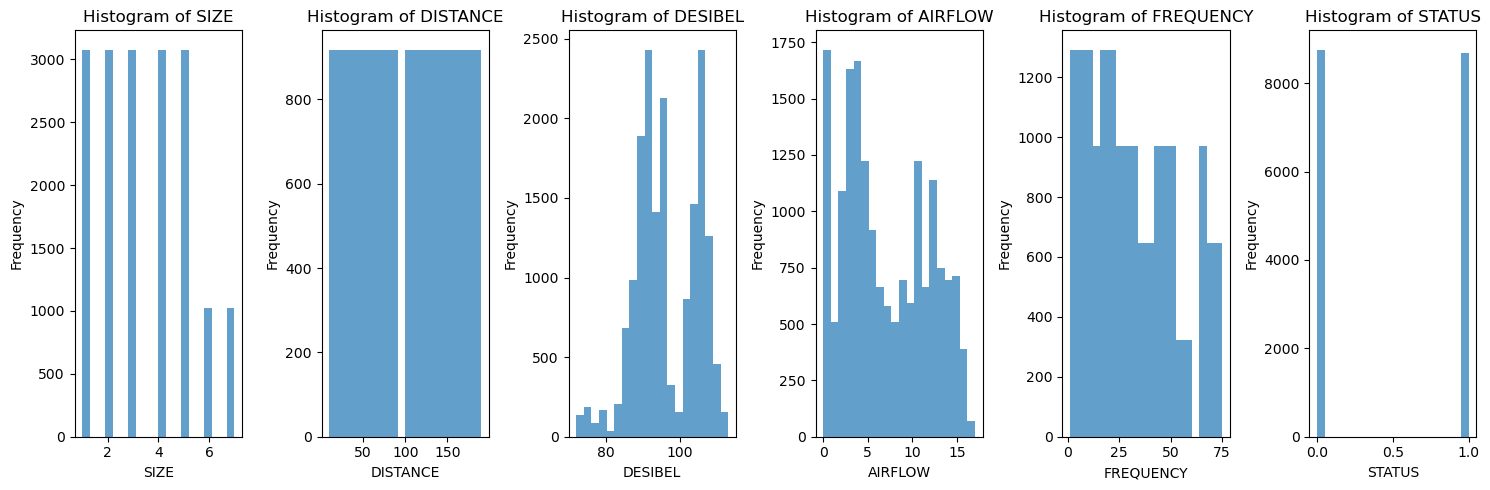

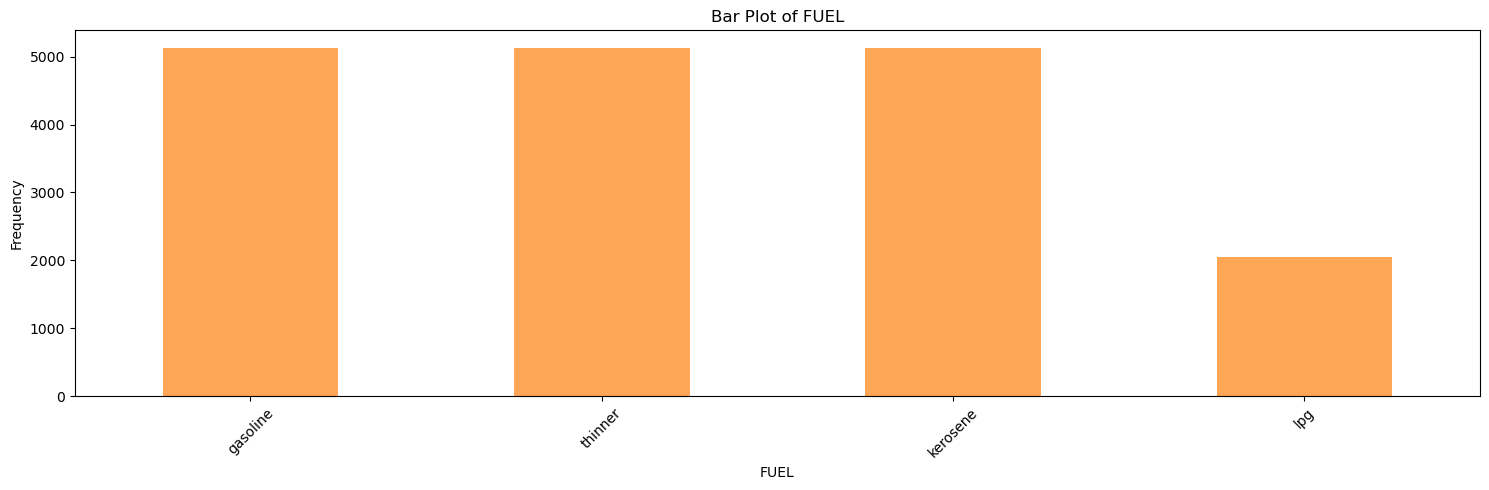

In [2]:
def plot_histograms(data):
    # Identify numeric and categorical variables
    numeric_variables = data.select_dtypes(include=['number']).columns.tolist()
    categorical_variables = [i for i in data.columns if i not in numeric_variables]
    
    # Plot histograms for numeric variables
    fig, axs = plt.subplots(1, len(numeric_variables), figsize=(15, 5))
    if len(numeric_variables) == 1:  # Handle case where there's only one numeric variable
        axs = [axs]
    
    for ax, var in zip(axs, numeric_variables):
        data[var].plot(kind='hist', ax=ax, bins=20, color='tab:blue', alpha=0.7)
        ax.set_title(f'Histogram of {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Plot bar plots for categorical variables
    fig, axs = plt.subplots(1, len(categorical_variables), figsize=(15, 5))
    if len(categorical_variables) == 1:  # Handle case where there's only one categorical variable
        axs = [axs]
    
    for ax, var in zip(axs, categorical_variables):
        # Fill missing values with 'Missing' label
        value_counts = data[var].fillna('Missing').value_counts()
        value_counts.plot(kind='bar', ax=ax, color='tab:orange', alpha=0.7)
        ax.set_title(f'Bar Plot of {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Frequency')
        
        # Rotate x-axis labels for better readability if necessary
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Call the function to plot histograms and bar plots for all variables
plot_histograms(data)


# Feature Engineering

In [3]:
#Custom mapping for FUEL categories
fuel_mapping = {
    'gasoline': 1,
    'kerosene': 2,
    'lpg': 3,
    'thinner': 4
}

#Map the 'FUEL' column to the new values
data['FUEL_encoded'] = data['FUEL'].map(fuel_mapping)

data = data.drop('FUEL', axis=1)

## Train-Test Split

In [4]:
X = data.drop('STATUS', axis=1)
y = data['STATUS']

X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13953, 6), (3489, 6), (13953,), (3489,))

In [5]:
X_train.head()

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,FUEL_encoded
9942,5,140,96,1.7,65,4
9624,5,80,106,10.5,48,4
8589,4,80,102,0.0,68,4
16957,7,110,96,0.0,72,3
4807,5,140,109,0.0,72,1


## Target Balance

In [6]:
(y_train == 0).sum(), (y_train == 1).sum()

# Seeing as though there isn't  much of a diference, leave it as is

(7045, 6908)

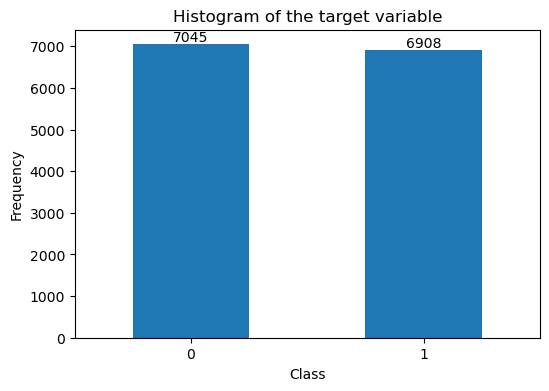

In [7]:
plt.figure(figsize=(6, 4))
value_counts = y_train.value_counts()
ax = value_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of the target variable')
plt.xticks([0, 1], ['0', '1'], rotation=0)  # Set x-tick labels as 0 and 1

# Add count on top of each bar
for index, value in enumerate(value_counts):
    ax.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

## Scaling/Transformations

In [8]:
scaler = StandardScaler()

# Fit the scaler to the training data and transform it (work directly with DataFrames)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Transform the test data (using the same scaler fit on the training data)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [9]:
X_train.head()

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,FUEL_encoded
0,0.904442,0.726825,-0.040336,-1.106301,1.595816,1.335804
1,0.904442,-0.369166,1.181838,0.751991,0.785298,1.335804
2,0.333855,-0.369166,0.692968,-1.465289,1.738849,1.335804
3,2.045616,0.178829,-0.040336,-1.465289,1.929559,0.494604
4,0.904442,0.726825,1.548490,-1.465289,1.929559,-1.187797


In [10]:
# use later to revert the transformation

stats = pd.DataFrame([X_train.columns, scaler.mean_, scaler.var_])
stats = stats.T
stats.columns = ['Feature', 'Mean', 'Variance']
stats.to_csv('stats.csv', index = True)

# Feature Selection

### Correlation Values

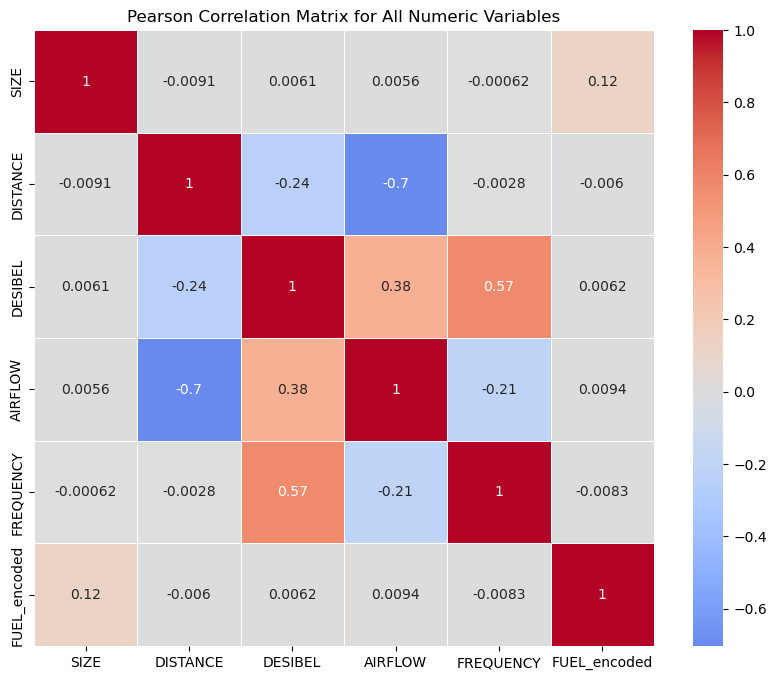

In [11]:
# Ensure you are selecting only numeric variables from the dataset
numeric_variables = X_train.select_dtypes(include=['number']).columns

# Compute the correlation matrix
correlation_matrix = X_train[numeric_variables].corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Pearson Correlation Matrix for All Numeric Variables')
plt.show()


There isn't any pair of features with a significantly high Pearson correlation value in order to justify removal

### RFE

In [12]:
model = LogisticRegression(max_iter=1000)

cv = StratifiedKFold(5)

# Initialize RFECV with the model and the cross-validation strategy
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy')

# Fit RFECV to the data
rfecv.fit(X_train , y_train)

# Get the selected features (boolean mask)
selected_features = X.columns[rfecv.support_]

    # Print the optimal number of features
print("Optimal number of features:", rfecv.n_features_)

X_train = X_train[selected_features]
X_test = X_test[selected_features]

Optimal number of features: 6


# Exporting the final dataframes

In [13]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

dataTrain = pd.concat([X_train, y_train], axis=1)
dataTest = pd.concat([X_test, y_test], axis=1)

dataTrain.to_csv('dataTrain.csv', index=False)
dataTest.to_csv('dataTest.csv', index=False)